In [24]:
from imports import *

Processing raw bus route list to convert it into a df with start, end, via stops

In [41]:
with open("../" + BUS_STOP_ROUTE_LIST_PATH, 'r') as f:
    reader = f.readlines()

routes = [route.strip() for route in reader]
routes[:5]

['7-ISBT-17 To New Maloya Colony Via SEC 22/23, SEC 38/25',
 '7-New Maloya Colony To ISBT 17 Via Maloya, Sector 38/25, Sector 23 MKT',
 '01-CTU Workshop To New Maloya Colony Via Dadu Majra village',
 '01-New Maloya Colony To ISBT 17 Via PGI, Sector 16 Hospital',
 '01-Mani Majra To New Maloya Colony Via Railway Station, ISBT-17, PGI']

In [42]:
def clean_tuple(data):
    return tuple(
        item.strip() if isinstance(item, str) else [i.strip() for i in item] if isinstance(item, list) else item
        for item in data
    )

def extract_stops(entry):
    route_number_idx = entry.find("-", 0, len(entry))

    route_number = entry[0 : route_number_idx]
    route_name = entry[route_number_idx+1 ::]

    start_stop = None
    end_stop = None
    via_stops = None

    route_name = route_name.lower()

    if "via" in route_name:
        sub_strs = route_name.split("via")
        start_stop, end_stop = re.split(r'\bto\b', sub_strs[0])

        via_stops = sub_strs[1].split(",")
    else:
        sub_strs = re.split(r'\bto\b', route_name)
        start_stop, end_stop = sub_strs[0], sub_strs[1]
    
    return clean_tuple((route_number, start_stop, end_stop, via_stops))

In [43]:
res = {
    'route_number': [],
    'start_stop': [], 
    'end_stop': [], 
    'via_stops': []
}

error_count = 0
for i, route in enumerate(routes):
    try:
        output = extract_stops(route)
        res['route_number'].append(output[0])
        res['start_stop'].append(output[1])
        res['end_stop'].append(output[2])
        res['via_stops'].append(output[3])
    except:
        print(i, route)
        error_count += 1

error_count

0

In [44]:
df = pd.DataFrame(res)
df

,route_number,start_stop,end_stop,via_stops
0,7,isbt-17,new maloya colony,"[sec 22/23, sec 38/25]"
1,7,new maloya colony,isbt 17,"[maloya, sector 38/25, sector 23 mkt]"
2,01,ctu workshop,new maloya colony,[dadu majra village]
3,01,new maloya colony,isbt 17,"[pgi, sector 16 hospital]"
4,01,mani majra,new maloya colony,"[railway station, isbt-17, pgi]"
...,...,...,...,...
376,38AS,isbt 17,new airport,"[i.s.b.t. 43, sohana]"
377,C551E,pgi,isbt 43,[isbt 17]
378,C551E,isbt 43,pgi,"[sec22/17, 16 hospital, new opd, pgi]"
379,C551E,pgi,workshop,None


In [46]:
df.to_csv("../scarping_scripts/scarped_data/processed_data/bus_routes_start_end.csv")

# Trying to Plot the bus routes

In [39]:
# Load the datasets
routes_df = pd.read_csv("../scarping_scripts/scarped_data/processed_data/bus_routes_start_end.csv")
stops_df = pd.read_csv("../" + BUS_STOP_LOCATIONS_PATH)

# Convert 'name' to lowercase for better matching
stops_df["name"] = stops_df["name"].str.lower()
routes_df["via_stops"] = routes_df["via_stops"].apply(lambda x: eval(x) if isinstance(x, str) else [])

# Function to get latitude and longitude of a stop with fuzzy matching
def get_coords(stop_name, threshold=85):
    # Normalize stop name (lowercase, remove extra spaces and dashes)
    stop_name = stop_name.lower().replace("-", " ").strip()
    
    # Get best match from stops dataset
    match = process.extractOne(stop_name, stops_df["name"])
    
    if match:  # Ensure a match was found
        best_match, score, *_ = match  # Unpack first two values
        
        # If match score is high enough, return its coordinates
        if score >= threshold:
            match_row = stops_df[stops_df["name"] == best_match].iloc[0]
            return match_row["lat"], match_row["long"]
    
    return None  # Return None if no good match found

# Load the road network for Chandigarh
G = ox.graph_from_place("Chandigarh, India", network_type="drive")

Getting all the routes and saving them in a geodf

In [31]:
for _, x in routes_df.iterrows():
    print(x["route_number"], x["start_stop"], x["end_stop"])

7 isbt-17 new maloya colony
7 new maloya colony isbt 17
01 ctu workshop new maloya colony
01 new maloya colony isbt 17
01 mani majra new maloya colony
01 new maloya colony manimajra
01 isbt 17 mani majra
01 new maloya colony ctu workshop
06 workshop isbt 43
06 isbt - 43 workshop
06 depot 3 new maloya colony
06 new maloya colony raipur kalan
06 raipur kalan new maloya colony
06 raipur kalan isbt-43
06 isbt 43 new maloya colony
06 new maloya colony isbt 43
08 phase 11 isbt 22/17
08 pgi isbt 17
08 pgi phase 11
08 isbt 17 phase 11
08 isbt 43 pgi
08 sector 22/17 pgi
08 phase 11 mohali pgi
08 phase 11 isbt 17
08 phase 11 mohali isbt 43
10 isbt-43 ctu workshop
10 isbt-43 manimajra
10 ctu workshop isbt-43
10 mani majra isbt-43
11 civil secretariat railway station
11 railway station civil secretariat
17 workshop isbt - 43
17 isbt- 43 behlana
17 isbt - 43 workshop
17 behlana isbt 43
18 isbt 43 isbt 17
18 isbt 17 isbt 43
18 isbt 43 sukhna lake
18 isbt 17 kaimbwala
18 sukhna lake isbt 17
18 isbt 4

In [ ]:
for _, route in routes_df.iterrows():
    start_coords = get_coords(route["start_stop"])
    end_coords = get_coords(route["end_stop"])
    
    if not start_coords or not end_coords:
        print(f"Skipping route {route} due to missing coordinates")
        failed_counter += 1
        continue

    via_coords = [get_coords(stop) for stop in route["via_stops"]]
    via_coords = [v for v in via_coords if v is not None]  # Remove None values

    # Find nearest nodes on the OSM graph
    try:
        start_node = ox.distance.nearest_nodes(G, start_coords[1], start_coords[0])
        end_node = ox.distance.nearest_nodes(G, end_coords[1], end_coords[0])
        via_nodes = [ox.distance.nearest_nodes(G, v[1], v[0]) for v in via_coords]

        # Compute route
        path = [start_node]
        for v_node in via_nodes:
            path += nx.shortest_path(G, path[-1], v_node, weight="length")[1:]  # Avoid duplicate nodes
        path += nx.shortest_path(G, path[-1], end_node, weight="length")[1:]

        # Plot on existing figure
        ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, ax=ax, show=False, close=False, route_alpha=0.1)

    except nx.NetworkXNoPath:
        print(f"No path found for route {route['route_number']} ({route['start_stop']} → {route['end_stop']}). Skipping.")
        failed_counter += 1


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


Skipping route 79 - chhatbir To pgi Via ['zirakpur', 'hallo majra', 'sector-20', 'sector-22/17']                due to missing coordinates (start- None, end - (30.76222, 76.77324))
Skipping route 79 - pgi To chhatbir Via ['isbt-17', 'sector-20', 'hallo majra', 'zirakpur']                due to missing coordinates (start- (30.76222, 76.77324), end - None)
Skipping route 79 - hallo majra To chhatbir Via []                due to missing coordinates (start- (30.69384, 76.79988), end - None)


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


Skipping route 213 - landran To hallomajra Via ['sohana', 'isbt 43']                due to missing coordinates (start- (30.69061, 76.66342), end - None)


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


Skipping route 70A - sp barrier To jayanti devi Via ['parch', 'sionk']                due to missing coordinates (start- (30.76472, 76.74688), end - None)
Skipping route 70A - jayanti majri To isbt-17 Via ['pec']                due to missing coordinates (start- None, end - (30.73637, 76.77837))
Skipping route 70A - jayanti majri To mata mansa devi Via ['pec', 'isbt-17', 'sector 27 market', 'railway station']                due to missing coordinates (start- None, end - (30.72377, 76.85816))
Skipping route 70A - mata mansa devi To jayanti majri Via ['railway station', 'sector 27 market', 'isbt-17', 'pec']                due to missing coordinates (start- (30.72377, 76.85816), end - None)


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


75


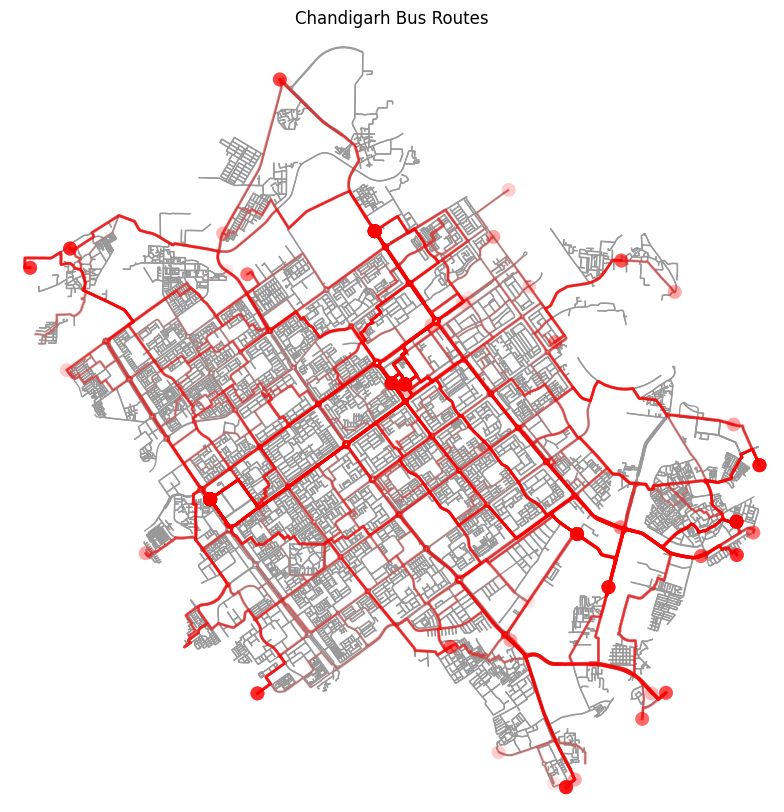

In [51]:
failed_counter = 0

# Initialize figure
fig, ax = plt.subplots(figsize=(12, 10))
ox.plot_graph(G, ax=ax, node_size=0, bgcolor="white", show=False, close=False)

# Iterate through each route and plot paths
for _, route in routes_df.iterrows():
    start_coords = get_coords(route["start_stop"])
    end_coords = get_coords(route["end_stop"])
    
    if not start_coords or not end_coords:
        print(f"Skipping route {route['route_number']} - {route['start_stop']} To {route['end_stop']} Via {route['via_stops']} \
               due to missing coordinates (start- {start_coords}, end - {end_coords})")
        failed_counter += 1
        continue

    via_coords = [get_coords(stop) for stop in route["via_stops"]]
    via_coords = [v for v in via_coords if v is not None]  # Remove None values

    # Find nearest nodes on the OSM graph
    try:
        start_node = ox.distance.nearest_nodes(G, start_coords[1], start_coords[0])
        end_node = ox.distance.nearest_nodes(G, end_coords[1], end_coords[0])
        via_nodes = [ox.distance.nearest_nodes(G, v[1], v[0]) for v in via_coords]

        # Compute route
        path = [start_node]
        for v_node in via_nodes:
            path += nx.shortest_path(G, path[-1], v_node, weight="length")[1:]  # Avoid duplicate nodes
        path += nx.shortest_path(G, path[-1], end_node, weight="length")[1:]

        # Plot on existing figure
        ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, ax=ax, show=False, close=False, route_alpha=0.1)

    except nx.NetworkXNoPath:
        # print(f"No path found for route {route['route_number']} ({route['start_stop']} → {route['end_stop']}). Skipping.")
        failed_counter += 1

# Final plot adjustments
ax.set_title("Chandigarh Bus Routes")
print(failed_counter)
plt.show()

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


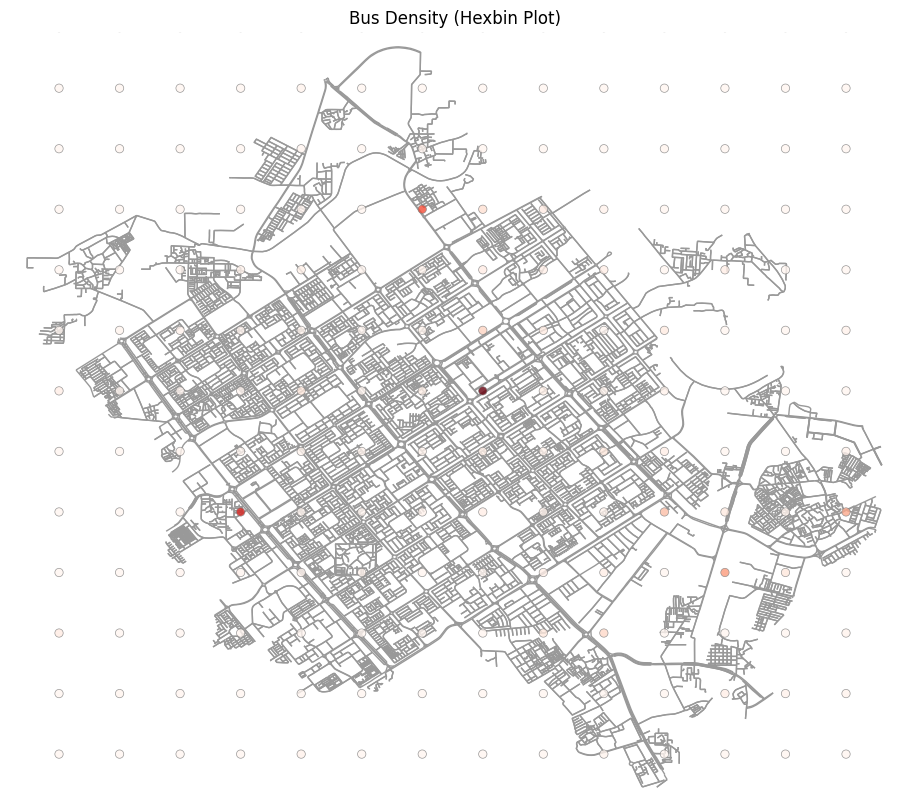

In [8]:
# Collect all coordinates (start, end, via stops)
all_coords = []

for _, route in routes_df.iterrows():
    start_coords = get_coords(route["start_stop"])
    end_coords = get_coords(route["end_stop"])
    via_coords = [get_coords(stop) for stop in route["via_stops"]]

    for coords in [start_coords, end_coords] + via_coords:
        if coords:
            all_coords.append(Point(coords[1], coords[0]))  # (longitude, latitude) for shapely

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=all_coords)

# Define hexagonal grid
xmin, ymin, xmax, ymax = gdf.total_bounds
hex_size = 0.01  # Adjust for detail level
x_bins = np.arange(xmin, xmax, hex_size)
y_bins = np.arange(ymin, ymax, hex_size)
hexagons = [Point(x, y) for x in x_bins for y in y_bins]

# Count points per hexagon
heatmap = gpd.GeoDataFrame(geometry=hexagons)
heatmap["count"] = heatmap.geometry.apply(lambda hex: sum(gdf.geometry.within(hex.buffer(hex_size / 2))))

# Plot hexbin map
fig, ax = plt.subplots(figsize=(12, 10))
ox.plot_graph(G, ax=ax, node_size=0, bgcolor="white", show=False, close=False)
heatmap.plot(column="count", cmap="Reds", linewidth=0.5, edgecolor="gray", alpha=0.8, ax=ax)
ax.set_title("Bus Density (Hexbin Plot)")
plt.show()

No path found for route 17 (behlana → isbt 43). Skipping.
No path found for route 26 (eco city → isbt-17). Skipping.
No path found for route 26 (eco city → ctu workshop). Skipping.
No path found for route 26 (dhakoli → pgi). Skipping.
No path found for route 26 (dhakoli → workshop). Skipping.
No path found for route 26 (eco city → dhakoli). Skipping.
No path found for route 2C (railway station → mani majra). Skipping.
No path found for route 2F (workshop → platinum homes/sanauli). Skipping.
No path found for route 2F (pgi → platinum homes/sanauli). Skipping.
No path found for route 2F (railway station → platinum homes/sanauli). Skipping.
No path found for route 2F (isbt 17 → platinum homes/sanauli). Skipping.
No path found for route 30 (isbt 43 → nada sahib). Skipping.
No path found for route 30 (sector 17 → nada sahib). Skipping.
No path found for route 30 (railway crossing → nada sahib). Skipping.
No path found for route 31 (omex tower → pgi). Skipping.
No path found for route 31 (om

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


No path found for route 219 (isbt 17 → bhabat). Skipping.
No path found for route 219 (dhanas → air force station). Skipping.
No path found for route 239 (lake → isbt 43). Skipping.
No path found for route 28A (rani majra → isbt 43). Skipping.
No path found for route 28A (sarangpur barrier → rani majra). Skipping.
No path found for route 28A (isbt- 43 → rani majra). Skipping.
No path found for route 30B (sector 4 panchkula → sector 26). Skipping.
No path found for route 30B (isbt 43 → ramgarh). Skipping.
No path found for route 30B (ramgarh → sector 22/17). Skipping.
No path found for route 30B (isbt 17 → ramgarh). Skipping.
No path found for route 30B (ramgarh → sector 26 grain mkt). Skipping.
No path found for route 32B (panchkula bus stand → housing borad). Skipping.
Skipping route 70A due to missing coordinates
Skipping route 70A due to missing coordinates
Skipping route 70A due to missing coordinates
Skipping route 70A due to missing coordinates
No path found for route 28 B (eco c

<Figure size 1500x1500 with 0 Axes>

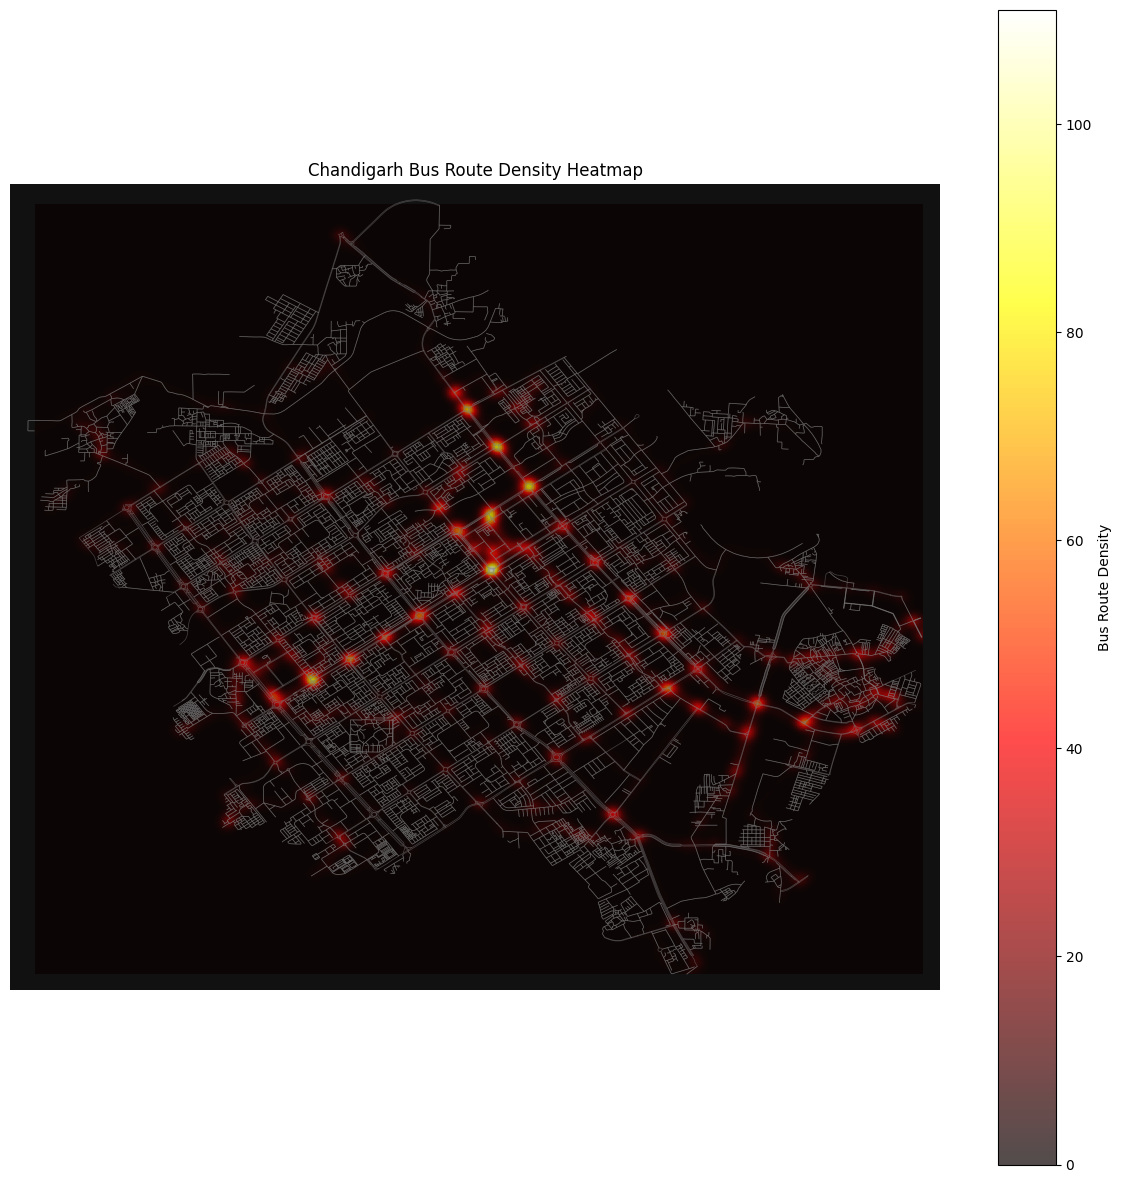

In [ ]:
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
from folium.plugins import HeatMap
from thefuzz import process
from collections import Counter

# Load datasets
routes_df = pd.read_csv("../scarping_scripts/scarped_data/processed_data/bus_routes_start_end.csv")
stops_df = pd.read_csv("../" + BUS_STOP_LOCATIONS_PATH)  # Replace with actual path

# Convert 'name' to lowercase for better matching
stops_df["name"] = stops_df["name"].str.lower()
routes_df["start_stop"] = routes_df["start_stop"].str.lower()
routes_df["end_stop"] = routes_df["end_stop"].str.lower()
routes_df["via_stops"] = routes_df["via_stops"].apply(lambda x: eval(x) if isinstance(x, str) else [])

# Function to get latitude and longitude of a stop with fuzzy matching
def get_coords(stop_name, threshold=85):
    # Normalize stop name (lowercase, remove extra spaces and dashes)
    stop_name = stop_name.lower().replace("-", " ").strip()
    
    # Get best match from stops dataset
    match = process.extractOne(stop_name, stops_df["name"])
    
    if match:  # Ensure a match was found
        best_match, score, *_ = match  # Unpack first two values
        
        # If match score is high enough, return its coordinates
        if score >= threshold:
            match_row = stops_df[stops_df["name"] == best_match].iloc[0]
            return match_row["lat"], match_row["long"]
    
    return None  # Return None if no good match found

# Load the road network for Chandigarh
G = ox.graph_from_place("Chandigarh, India", network_type="drive")

# Dictionary to count how many routes use each edge
edge_counts = Counter()
failed_counter = 0

# Iterate through each route and accumulate edge usage
for _, route in routes_df.iterrows():
    start_coords = get_coords(route["start_stop"])
    end_coords = get_coords(route["end_stop"])
    
    if not start_coords or not end_coords:
        print(f"Skipping route {route['route_number']} due to missing coordinates")
        failed_counter += 1
        continue
    
    via_coords = [get_coords(stop) for stop in route["via_stops"]]
    via_coords = [v for v in via_coords if v is not None]  # Remove None values
    
    # Find nearest nodes on the OSM graph
    try:
        start_node = ox.distance.nearest_nodes(G, start_coords[1], start_coords[0])
        end_node = ox.distance.nearest_nodes(G, end_coords[1], end_coords[0])
        via_nodes = [ox.distance.nearest_nodes(G, v[1], v[0]) for v in via_coords]
        
        # Compute route through all via points
        path = [start_node]
        for v_node in via_nodes:
            segment = nx.shortest_path(G, path[-1], v_node, weight="length")[1:]  # Avoid duplicate nodes
            path += segment
        path += nx.shortest_path(G, path[-1], end_node, weight="length")[1:]
        
        # Count edges in the path
        for i in range(len(path)-1):
            edge = (path[i], path[i+1])
            edge_counts[edge] += 1
            
    except nx.NetworkXNoPath:
        print(f"No path found for route {route['route_number']} ({route['start_stop']} → {route['end_stop']}). Skipping.")
        failed_counter += 1

print(f"Failed to process {failed_counter} routes")

# ------------------------------------------------------------
# SIMPLIFIED APPROACH: Create a matplotlib heatmap instead
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Create an empty grid to represent the city
# Get the bounding box of the network
nodes = ox.graph_to_gdfs(G, edges=False)
min_x, min_y, max_x, max_y = nodes.x.min(), nodes.y.min(), nodes.x.max(), nodes.y.max()

# Create a grid
grid_size = 500
x_grid = np.linspace(min_x, max_x, grid_size)
y_grid = np.linspace(min_y, max_y, grid_size)
heatmap_grid = np.zeros((grid_size, grid_size))

# Function to find the grid cell for a coordinate
def get_grid_indices(x, y):
    x_idx = np.argmin(np.abs(x_grid - x))
    y_idx = np.argmin(np.abs(y_grid - y))
    return x_idx, y_idx

# Fill the grid with edge counts
for edge, count in edge_counts.items():
    u, v = edge
    try:
        # Get coordinates for both nodes
        u_lat, u_lng = G.nodes[u]['y'], G.nodes[u]['x']
        v_lat, v_lng = G.nodes[v]['y'], G.nodes[v]['x']
        
        # Add points along the edge to increase visibility
        steps = 10
        for step in range(steps+1):
            frac = step / steps
            lng = u_lng + frac * (v_lng - u_lng)
            lat = u_lat + frac * (v_lat - u_lat)
            
            # Add to the heat grid
            x_idx, y_idx = get_grid_indices(lng, lat)
            heatmap_grid[y_idx, x_idx] += count
    except Exception as e:
        print(f"Error processing edge {edge}: {e}")

# Apply Gaussian smoothing to make the heatmap look better
from scipy.ndimage import gaussian_filter
smoothed_grid = gaussian_filter(heatmap_grid, sigma=3)

# Plot the heatmap with matplotlib
plt.figure(figsize=(15, 15))

# Add the base map using OSMnx
ox.plot_graph(G, figsize=(15, 15), node_size=0, edge_color='gray', 
              edge_linewidth=0.5, edge_alpha=0.5, show=False)

# Overlay the heatmap with transparency
plt.imshow(smoothed_grid, extent=[min_x, max_x, min_y, max_y], 
           alpha=0.7, cmap='hot', origin='lower')

# Add colorbar
cbar = plt.colorbar(label='Bus Route Density')

plt.title('Chandigarh Bus Route Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot
plt.savefig('chandigarh_bus_route_density_heatmap.png', dpi=300, bbox_inches='tight')
print("Matplotlib heatmap saved successfully!")

# ------------------------------------------------------------
# ALTERNATIVE: Try a completely minimal folium approach as a separate output
# ------------------------------------------------------------

try:
    # Create a very simple map with just the heatmap data points
    minimal_map = folium.Map(location=[30.7333, 76.7794], zoom_start=12)
    
    # Create simplified heatmap data
    minimal_data = []
    for edge, count in edge_counts.items():
        u, v = edge
        try:
            # Get coordinates for both nodes (mid-point only)
            u_lat, u_lng = float(G.nodes[u]['y']), float(G.nodes[u]['x'])
            v_lat, v_lng = float(G.nodes[v]['y']), float(G.nodes[v]['x'])
            
            # Just use the midpoint of each edge
            lat = float((u_lat + v_lat) / 2)
            lng = float((u_lng + v_lng) / 2)
            weight = float(count)
            
            minimal_data.append([lat, lng, weight])
        except:
            continue
    
    # Pure Python handling without extra parameters
    HeatMap(minimal_data).add_to(minimal_map)
    minimal_map.save('minimal_bus_route_heatmap.html')
    print("Minimal folium heatmap saved successfully!")
except Exception as e:
    print(f"Even minimal folium approach failed: {e}")

# Display summary
print(f"Processed {len(routes_df) - failed_counter} routes successfully")
print(f"Failed to process {failed_counter} routes")
print(f"Maximum route overlap on any edge: {max(edge_counts.values()) if edge_counts else 0}")